# JaxMARL Example Usage

Welcome to a walkthrough of the JaxMARL repo. We include several popular MARL environemnts and algorithms, allowing you to easily evaluate your new approach! This colab will showcase our API, the speed of our environments and how to train over multiple seeds.

⚠️ Ensure you select a GPU from `Runtime > Change runtime type` ⚠️

### Install dependencies 📚

We install JAX for use with a GPU, there is rather a lot to download so this may take a second or two.

Note, that the runtime will reboot automatically immediately after.


## Part 1: JaxMARL API 🕹️

Our API is inspired by [PettingZoo](https://github.com/Farama-Foundation/PettingZoo) and [Gymnax](https://github.com/RobertTLange/gymnax), making it familiar to MARL researchers. Below, an MPE scenario is instatiated from JaxMARL's registry and a trajectory is sampled using random actions. We then visualise the results. Examples for more JaxMARL environments can be found [here](https://github.com/FLAIROx/JaxMARL/tree/main/jaxmarl/tutorials).

* `actions`, `obs`, `rewards`, `dones` are dictionaries keyed by agent name, this allows for differing action and observation spaces. As agents can terminate asychronously, `dones` contains a special `"__all__"` which signifies whether an episode has terminated.
* `state` represents the internal state of the environment and contains all the information needed to transistion the environment given a set of actions. These variables are not held within the environment class due to JAX transformations requiring pure functions.
* `info` is a dictionary containing pertinent information, the exact content varies environment to environment.


list of agents in environment ['agent_0', 'agent_1']
example action dict {'agent_0': Array(40, dtype=int32), 'agent_1': Array(37, dtype=int32)}
Comm active?  True
comm idx [0 1]


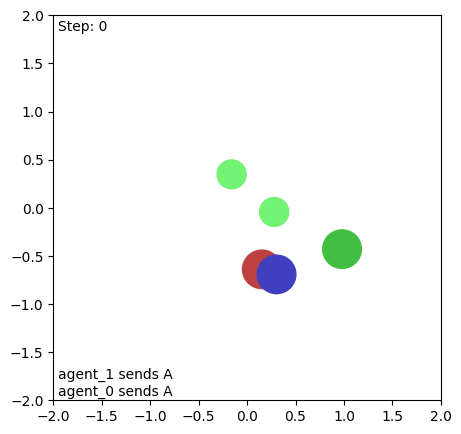

In [6]:
import matplotlib.animation as animation
import jax
from jaxmarl import make
from jaxmarl.environments.mpe import MPEVisualizer

# Parameters + random keys
max_steps = 25
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)

# Instantiate environment
env = make('MPE_simple_reference_v3')
obs, state = env.reset(key_r)
print('list of agents in environment', env.agents)

# Sample random actions
key_a = jax.random.split(key_a, env.num_agents)
actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}
print('example action dict', actions)

# Collect trajectory
state_seq = []
for _ in range(max_steps):
    state_seq.append(state)
    # Iterate random keys and sample actions
    key, key_s, key_a = jax.random.split(key, 3)
    key_a = jax.random.split(key_a, env.num_agents)
    actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}

    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

# Visualise
viz = MPEVisualizer(env, state_seq)
ani = animation.FuncAnimation(
    viz.fig,
    viz.update,
    frames=len(viz.state_seq),
    blit=False,
    interval=viz.interval,
)

from IPython.display import HTML
HTML(ani.to_html5_video())

## Part 2: Compare speed 🚀

We can then compare the speed of JaxMARL's MPE environments to the CPU-based ones provided by PettingZoo. We again take random actions and compare the number of environment steps per second between the two implementations.

We also show how JaxMARL environments can be simply vectorised, using `jax.vmap`, to greatly increase the number of environment steps per second.

In [2]:
MPE_ENV = "MPE_simple_reference_v3"

In [3]:
import numpy as np
import jaxmarl
import jax

def make_benchmark(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]

    def benchmark(rng):
        def init_runner_state(rng):

            # INIT ENV
            rng, _rng = jax.random.split(rng)
            reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state = jax.vmap(env.reset)(reset_rng)

            return (env_state, obsv, rng)

        def env_step(runner_state, unused):
            env_state, last_obs, rng = runner_state

            # SELECT ACTION
            rng, _rng = jax.random.split(rng)
            rngs = jax.random.split(_rng, config["NUM_ACTORS"]).reshape((env.num_agents, config["NUM_ENVS"], -1))
            actions = {k: jax.vmap(env.action_space(k).sample)(rngs[i]) for i, k in enumerate(env.agents)}

            # STEP ENV
            rng, _rng = jax.random.split(rng)
            rng_step = jax.random.split(_rng, config["NUM_ENVS"])
            obsv, env_state, _, _, info = jax.vmap(env.step)(
                rng_step, env_state, actions
            )
            runner_state = (env_state, obsv, rng)
            return runner_state, None

        rng, init_rng = jax.random.split(rng)
        runner_state = init_runner_state(init_rng)
        runner_state = jax.lax.scan(env_step, runner_state, None, config["NUM_STEPS"])
        return runner_state

    return benchmark

In [4]:
import time
import jax
import jax.numpy as jnp
from jaxmarl.environments.mpe.simple_world_comm import SimpleWorldCommMPE
from pettingzoo.mpe import simple_v3, simple_tag_v3, simple_world_comm_v3, simple_reference_v3, simple_spread_v3, simple_crypto_v3, simple_speaker_listener_v4, simple_push_v3, simple_adversary_v3
import time

config = {
    "NUM_STEPS": 1000,
    "NUM_ENVS": 1000,
    "ACTIVATION": "relu",
    "ENV_KWARGS": {},
    "ENV_NAME": MPE_ENV,
    "NUM_SEEDS": 1,
    "SEED": 0,
}

### JAXMARL BENCHMARK
num_envs = [1, 100, 1000, 10000]
jaxmarl_sps = []
for num in num_envs:
  config["NUM_ENVS"] = num
  benchmark_fn = jax.jit(make_benchmark(config))
  rng = jax.random.PRNGKey(config["SEED"])
  rng, _rng = jax.random.split(rng)
  benchmark_jit = jax.jit(benchmark_fn).lower(_rng).compile()
  before = time.perf_counter_ns()
  runner_state = jax.block_until_ready(benchmark_jit(_rng))
  after = time.perf_counter_ns()
  total_time = (after - before) / 1e9

  sps = config['NUM_STEPS'] * config['NUM_ENVS'] / total_time
  jaxmarl_sps.append(sps)

  print(f"JaxMARL, Num Envs: {num}, Total Time (s): {total_time}")
  print(f"JaxMARL, Num Envs: {num}, Total Steps: {config['NUM_STEPS'] * config['NUM_ENVS']}")
  print(f"JaxMARL, Num Envs: {num}, SPS: {sps}")


### PETTING ZOO BENCHMARK
zoo_mpe_env_mapper = {
    "MPE_simple_v3": simple_v3,
    "MPE_simple_world_comm_v3": simple_world_comm_v3,
    "MPE_simple_tag_v3": simple_tag_v3,
    "MPE_simple_spread_v3": simple_spread_v3,
    "MPE_simple_crypto_v3": simple_crypto_v3,
    "MPE_simple_speaker_listener_v4": simple_speaker_listener_v4,
    "MPE_simple_push_v3": simple_push_v3,
    "MPE_simple_adversary_v3": simple_adversary_v3,
    "MPE_simple_reference_v3": simple_reference_v3,
}
zoo_env = zoo_mpe_env_mapper[config["ENV_NAME"]]
env = zoo_env.parallel_env(max_cycles=max_steps)
obs = env.reset()

start_time = time.time()
actions = {agent: env.action_space(agent).sample() for agent in env.agents}

for _ in range(config["NUM_STEPS"]):
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}  # this is where you would insert your policy
    observations, rewards, terminations, truncations, infos = env.step(actions)

zoo_time = time.time() - start_time
zoo_sps = config["NUM_STEPS"]/zoo_time


print(f"PettingZoo Total Time (s): {zoo_time}")
print(f"PettingZoo Total Steps: {config['NUM_STEPS']}")
print(f"PettingZoo SPS: {zoo_sps}")


/var/folders/17/q73v4njs7p32tr4q5vlhg7gh0000gn/T/ipykernel_45689/41762189.py:5: DeprecationWarning: The environment `pettingzoo.mpe` has been moved to `mpe2` and will be removed in a future release.Please update your imports.
  from pettingzoo.mpe import simple_v3, simple_tag_v3, simple_world_comm_v3, simple_reference_v3, simple_spread_v3, simple_crypto_v3, simple_speaker_listener_v4, simple_push_v3, simple_adversary_v3
/Users/tomas/Documents/marl-dreamer/.venv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


JaxMARL, Num Envs: 1, Total Time (s): 0.053237361
JaxMARL, Num Envs: 1, Total Steps: 1000
JaxMARL, Num Envs: 1, SPS: 18783.801097879365
JaxMARL, Num Envs: 100, Total Time (s): 0.484714262
JaxMARL, Num Envs: 100, Total Steps: 100000
JaxMARL, Num Envs: 100, SPS: 206307.11295224898
JaxMARL, Num Envs: 1000, Total Time (s): 7.48070894
JaxMARL, Num Envs: 1000, Total Steps: 1000000
JaxMARL, Num Envs: 1000, SPS: 133677.16990737512
JaxMARL, Num Envs: 10000, Total Time (s): 31.834242818
JaxMARL, Num Envs: 10000, Total Steps: 10000000
JaxMARL, Num Envs: 10000, SPS: 314127.15097925026
PettingZoo Total Time (s): 0.031932830810546875
PettingZoo Total Steps: 1000
PettingZoo SPS: 31315.732887349182


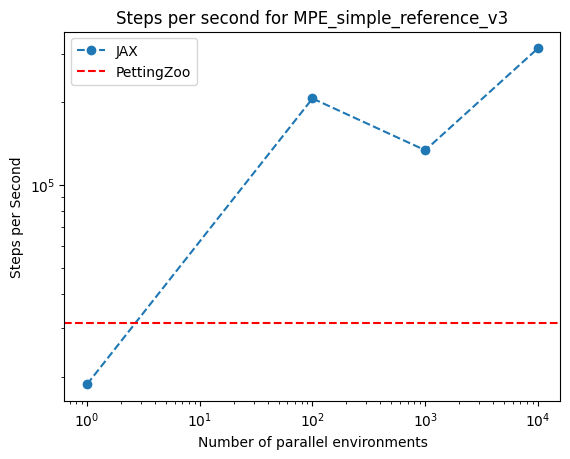

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(num_envs, jaxmarl_sps, linestyle='--', marker='o', label="JAX")
plt.axhline(y=zoo_sps, color='r', linestyle='--', label="PettingZoo")
plt.legend()

plt.ylabel("Steps per Second")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of parallel environments")
plt.title(f"Steps per second for {MPE_ENV}")
plt.show()

## Part 3: Train an agent 🍲

We train an agent on the `cramped_room` Overcooked scenario using IPPO, our IPPO code is based off [PureJaxRL](https://github.com/luchris429/purejaxrl). Here we also show how `jax.vmap` can again be used to simply train over multiple seeds.

In [12]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import jaxmarl
from jaxmarl.wrappers.baselines import LogWrapper
from jaxmarl.environments.overcooked import overcooked_layouts
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
import hydra
from omegaconf import OmegaConf

import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def get_rollout(train_state, config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
    key = jax.random.PRNGKey(0)
    key, key_r, key_a = jax.random.split(key, 3)

    init_x = jnp.zeros(env.observation_space().shape)
    init_x = init_x.flatten()

    network.init(key_a, init_x)
    network_params = train_state.params

    done = False

    obs, state = env.reset(key_r)
    state_seq = [state]
    while not done:
        key, key_a0, key_a1, key_s = jax.random.split(key, 4)

        # obs_batch = batchify(obs, env.agents, config["NUM_ACTORS"])
        # breakpoint()
        obs = {k: v.flatten() for k, v in obs.items()}

        pi_0, _ = network.apply(network_params, obs["agent_0"])
        pi_1, _ = network.apply(network_params, obs["agent_1"])

        actions = {"agent_0": pi_0.sample(seed=key_a0), "agent_1": pi_1.sample(seed=key_a1)}
        # env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)
        # env_act = {k: v.flatten() for k, v in env_act.items()}

        # STEP ENV
        obs, state, reward, done, info = env.step(key_s, state, actions)
        done = done["__all__"]

        state_seq.append(state)

    return state_seq

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

def make_train(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space("agent_0").n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space("agent_0").shape)

        init_x = init_x.flatten()

        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                env_act = {k:v.flatten() for k,v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0))(
                    rng_step, env_state, env_act
                )
                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info

                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train



In [ ]:
%matplotlib inline

# set hyperparameters:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "overcooked",
    "ENV_KWARGS": {
      "layout" : "cramped_room"
    },
    "ANNEAL_LR": True,
    "SEED": 0,
    "NUM_SEEDS": 3
}

config["ENV_KWARGS"]["layout"] = overcooked_layouts[config["ENV_KWARGS"]["layout"]]
rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])
with jax.disable_jit(False):
    train_jit = jax.jit(jax.vmap(make_train(config)))
    out = train_jit(rngs)


for i in range(config["NUM_SEEDS"]):
    plt.plot(out["metrics"]["returned_episode_returns"][i].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

TypeError: cannot reshape array of shape (16,) (size 16) into shape 32 (size 32)